# Install Dependencies


In [ ]:
!pip install tensorflow==2.15.0 keras==2.15 tensorflow-hub==0.13.0 tensorflow-text==2.15.0
!pip install datasets
!pip -q install evaluate
!pip install imbalanced-learn
!pip install transformers datasets scikit-learn imbalanced-learn evaluate

# Import Libraries

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import keras
from keras.layers import Input
import numpy as np


import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report



# Tensor Flow

import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


# Check if libraries are installed and print their versions
try:
    print(f"TensorFlow Hub Version: {hub.__version__}")
except ImportError:
    print("TensorFlow Hub is not installed.")

try:
    print(f"TensorFlow Text Version: {text.__version__}")
except ImportError:
    print("TensorFlow Text is not installed.")

try:
    print(f"TensorFlow Version: {tf.__version__}")
except ImportError:
    print("TensorFlow is not installed.")

try:
    print(f"pandas Version: {pd.__version__}")
except ImportError:
    print("pandas is not installed.")

try:
    print(f"scikit-learn Version: {train_test_split.__module__.split('.')[0]}")
except ImportError:
    print("scikit-learn is not installed.")

try:
    print(f"scikit-learn Version: {classification_report.__module__.split('.')[0]}")
except ImportError:
    print("scikit-learn is not installed.")

#other usefull

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
# from imblearn.over_sampling import SMOTE
# from imblearn.over_sampling import RandomOverSampler


# Import Libraries

from transformers import DistilBertForSequenceClassification, DistilBertTokenizer, Trainer, TrainingArguments, DataCollatorWithPadding
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from imblearn.over_sampling import RandomOverSampler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import Dataset, DatasetDict



# Import Github

In [ ]:
!git clone https://github.com/tajuar-akash-hub/Datasets.git

# Dataset Location

In [ ]:
my_df_loc = '/kaggle/working/Datasets/generated_with_gemini.csv'

# BERT Variations


## DistilBERT

In [ ]:
pip install --upgrade sympy


In [ ]:
# Load the Dataset
data = pd.read_csv(my_df_loc)
data.dropna(inplace=True)


In [ ]:
data.columns

In [ ]:
data = data[['Generated_using_gemini', 'fraud_status']]
data['fraud_status'] = data['fraud_status'].astype(int)

In [ ]:
# Train-Test Split
train_data, test_data = train_test_split(data, test_size=0.2, stratify=data['fraud_status'], random_state=42)


In [ ]:
# Oversampling on Training Data Only
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(
    train_data[['Generated_using_gemini']], train_data['fraud_status']
)

In [ ]:
# Combine Resampled Training Data
train_data_resampled = pd.DataFrame({
    'Generated_using_gemini': X_train_resampled['Generated_using_gemini'].values,
    'fraud_status': y_train_resampled.values
})

In [ ]:
# Tokenization
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')


In [ ]:
def tokenize_function(data):
    return tokenizer(
        data['Generated_using_gemini'].tolist(),
        padding='max_length',
        truncation=True,
        max_length=512,
        return_tensors='np'
    )


In [ ]:
train_encodings = tokenize_function(train_data_resampled)
test_encodings = tokenize_function(test_data)


In [ ]:
# Convert to Hugging Face Dataset
train_dataset = Dataset.from_dict({
    'input_ids': train_encodings['input_ids'],
    'attention_mask': train_encodings['attention_mask'],
    'labels': train_data_resampled['fraud_status'].values
})
test_dataset = Dataset.from_dict({
    'input_ids': test_encodings['input_ids'],
    'attention_mask': test_encodings['attention_mask'],
    'labels': test_data['fraud_status'].values
})


In [ ]:
# Model Initialization
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)


In [ ]:
# Define Metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef

def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, predictions),
        "precision": precision_score(labels, predictions, average="weighted"),
        "recall": recall_score(labels, predictions, average="weighted"),
        "f1": f1_score(labels, predictions, average="weighted"),
        "mcc": matthews_corrcoef(labels, predictions)
    }

In [ ]:
# Training Arguments
training_args = TrainingArguments(
    output_dir="./distilbert-results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir="./logs",
    save_total_limit=3,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    report_to="none"
)

In [ ]:
# Trainer Initialization
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [49]:
# Train the Model

trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Mcc
1,No log,0.407973,0.927596,0.880191,0.927596,0.903272,-0.026903
2,0.184900,0.518259,0.922131,0.879867,0.922131,0.900503,-0.033041
3,0.010800,0.588534,0.926230,0.891854,0.926230,0.906719,0.051709
4,0.010800,0.594380,0.933060,0.880511,0.933060,0.906024,-0.018971
5,0.003100,0.616978,0.928962,0.888239,0.928962,0.906189,0.023055


TrainOutput(global_step=1715, training_loss=0.058016948532258805, metrics={'train_runtime': 809.517, 'train_samples_per_second': 33.897, 'train_steps_per_second': 2.119, 'total_flos': 3876525954269184.0, 'train_loss': 0.058016948532258805, 'epoch': 5.0})

In [50]:
# Evaluate the Model

results = trainer.evaluate()
print("Evaluation Results:", results)


Evaluation Results: {'eval_loss': 0.5885342359542847, 'eval_accuracy': 0.9262295081967213, 'eval_precision': 0.8918536148181146, 'eval_recall': 0.9262295081967213, 'eval_f1': 0.9067185212048502, 'eval_mcc': 0.05170923685246765, 'eval_runtime': 6.1803, 'eval_samples_per_second': 118.441, 'eval_steps_per_second': 7.443, 'epoch': 5.0}


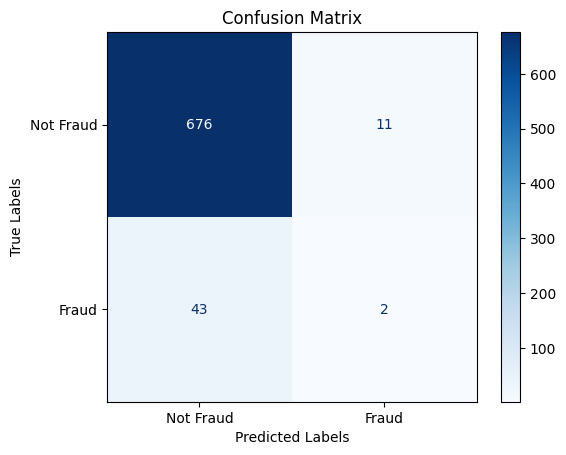

In [51]:
# Generate Metrics for Confusion Matrix and ROC Curve
predictions = trainer.predict(test_dataset)
true_labels = predictions.label_ids
predicted_labels = np.argmax(predictions.predictions, axis=-1)
predicted_probabilities = predictions.predictions[:, 1]  # Positive class probabilities


# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Fraud", "Fraud"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()



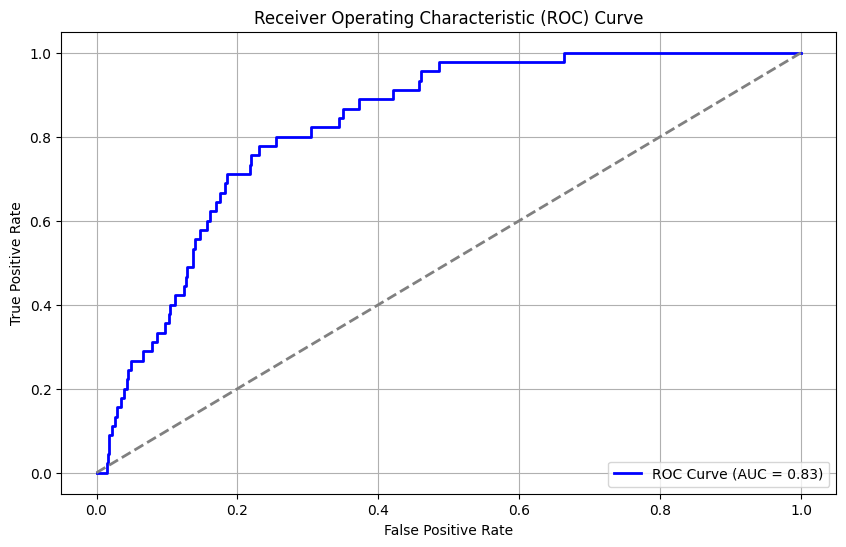

In [52]:
# ROC Curve

fpr, tpr, thresholds = roc_curve(true_labels, predicted_probabilities)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [53]:
# Training and Validation Loss Curves
train_logs = trainer.state.log_history
train_loss = [log['loss'] for log in train_logs if 'loss' in log]
val_loss = [log['eval_loss'] for log in train_logs if 'eval_loss' in log]


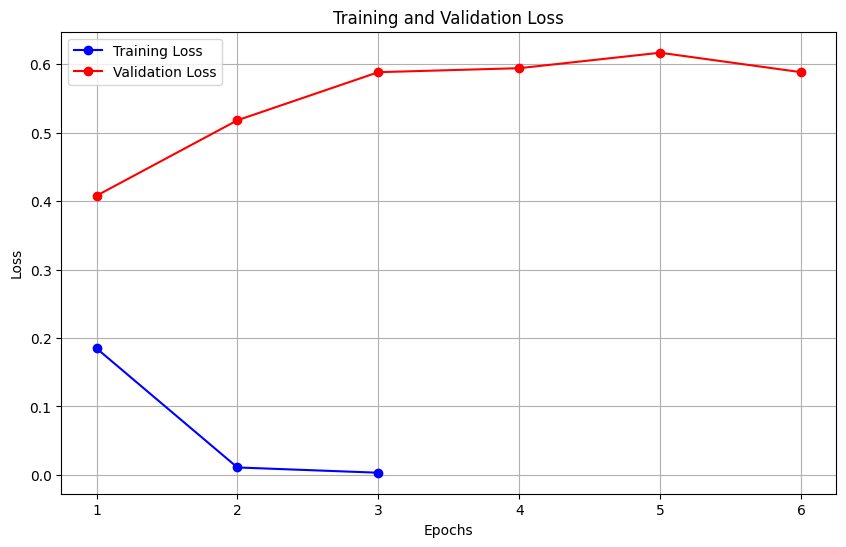

In [54]:
# Plot Training and Validation Loss

plt.figure(figsize=(10, 6))
epochs_train = range(1, len(train_loss) + 1)
epochs_val = range(1, len(val_loss) + 1)
plt.plot(epochs_train, train_loss, marker='o', label='Training Loss', color='b')
plt.plot(epochs_val, val_loss, marker='o', label='Validation Loss', color='r')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

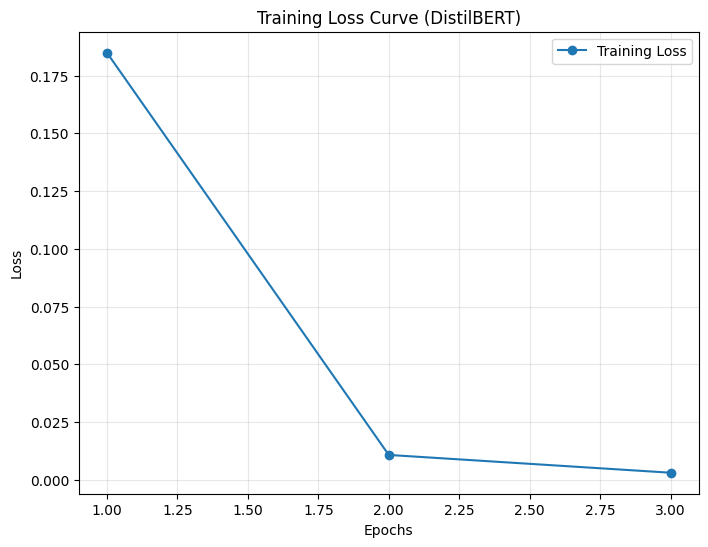

In [55]:
import matplotlib.pyplot as plt

# Fetch log history from the trainer
train_metrics = trainer.state.log_history

# Extract training loss values
train_loss = [log["loss"] for log in train_metrics if "loss" in log]  # Training loss

# Plot Training Loss Curve
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_loss) + 1), train_loss, label="Training Loss", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Curve (DistilBERT)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()
